In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io 
import os

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams.update({'font.size': 14})


vortall_mat = scipy.io.loadmat('VORTALL.mat')
vortall = vortall_mat['VORTALL']


# vortall contains 151 snapshots
m, n = np.shape(vortall) 

print("number of datapoints:", m)
print("number of snapshots", n)

number of datapoints: 89351
number of snapshots 151


In [2]:
# a) Compute the SVD of this data set 

U, S, VT = np.linalg.svd(vortall,full_matrices=False)
S = np.diag(S)


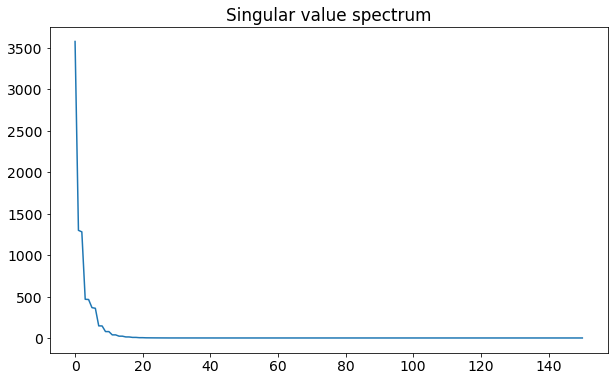

In [3]:
# plot the singular value spectrum

plt.plot(np.diag(S))
plt.title("Singular value spectrum")
plt.show()

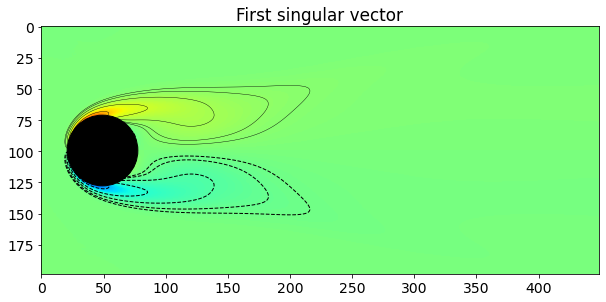

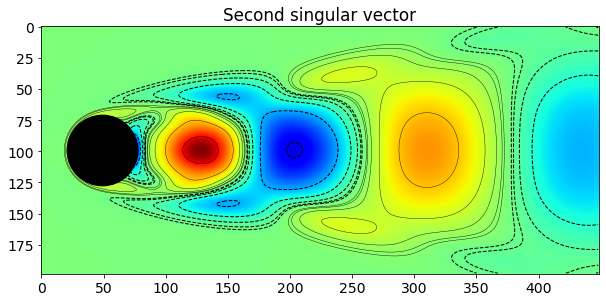

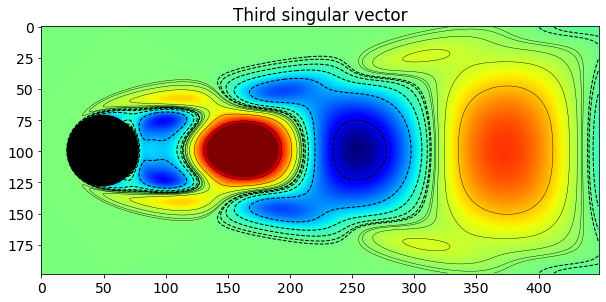

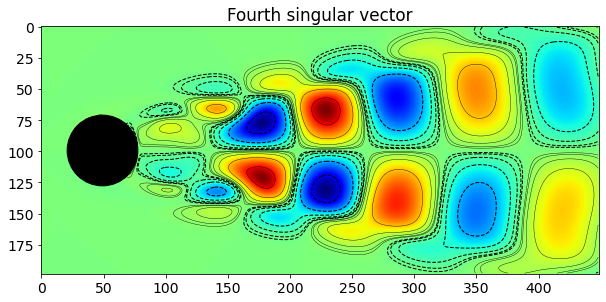

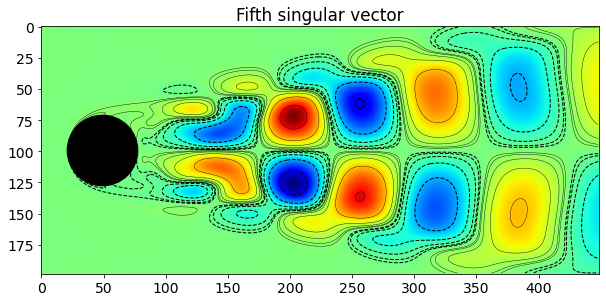

In [4]:
# plot the leading singular vectors.
# The U matrix contains the eigenflow fields and the SigmaV* represents the amplitudes of the eigenflows as the flow evolves 
# in time.

#From CH7 - 7.2 
def EigenflowField(vortall):
    vortmin = -5
    vortmax = 5
    V2 = np.copy(np.real(np.reshape(vortall,(449,199))))
    V2 = V2.T

    # normalize values... not symmetric
    minval = np.min(V2)
    maxval = np.max(V2)

    if np.abs(minval) < 5 and np.abs(maxval) < 5:
        if np.abs(minval) > np.abs(maxval):
            vortmax = maxval
            vortmin = -maxval
        else:
            vortmin = minval
            vortmax = -minval

    V2[V2 > vortmax] = vortmax
    V2[V2 < vortmin] = vortmin

    plt.figure(1)
    plt.imshow(V2,cmap='jet',vmin=vortmin,vmax=vortmax)

    cvals = np.array([-4,-2,-1,-0.5,-0.25,-0.155])
    plt.contour(V2,cvals*vortmax/5,colors='k',linestyles='dashed',linewidths=1)
    plt.contour(V2,np.flip(-cvals)*vortmax/5,colors='k',linestyles='solid',linewidths=0.4)
    plt.scatter(49,99,5000,color='k') # draw cylinder
    plt.show()


plt.title('First singular vector')
EigenflowField(U[:,0])
plt.title('Second singular vector')
EigenflowField(U[:,1])
plt.title('Third singular vector')
EigenflowField(U[:,2])
plt.title('Fourth singular vector')
EigenflowField(U[:,3])
plt.title('Fifth singular vector')
EigenflowField(U[:,4])

plt.show()


In [9]:
#b) Write a code to plot the reconstructed movie for various truncation ovalues r.
#    ???

# Compute the r value needed to capture 90%, 99% and 99.9% of the flow energy based on the singular value spectrum
# Recall the energy is given by the Forbenius norm squared
# Plot the movied for each of these truncation values and compare the fidelity. Also compute the reconstructed matrix
# Xtilde, where X is the flow field movie

vortall_fro = np.linalg.norm(vortall, 'fro')
S2 = np.square(np.diag(S))
energy_cdS = np.sqrt(np.cumsum(S2))/vortall_fro
#print("energy cdS", energy_cdS)

rank_90 = np.where(np.logical_and(energy_cdS >= 0.90, energy_cdS <=0.94))
rank_99 = np.where(np.logical_and(energy_cdS >= 0.990, energy_cdS <=0.997))
rank_999 = np.where(np.logical_and(energy_cdS >= 0.998, energy_cdS <=0.999))

rank_90_0 = rank_90[0]
rank_99_0 = rank_99[0]
rank_999_0 = rank_999[0]
print("r value needed to capture 90% of the flow energy is",rank_90_0[0])
print("r value needed to capture 99% of the flow energy is",rank_99_0[0])
print("r value needed to capture 999% of the flow energy is",rank_999_0[0])


r value needed to capture 90% of the flow energy is 1
r value needed to capture 99% of the flow energy is 4
r value needed to capture 999% of the flow energy is 6


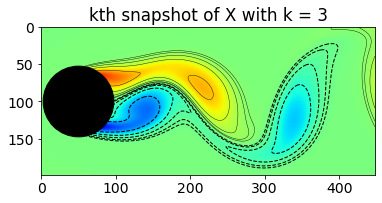

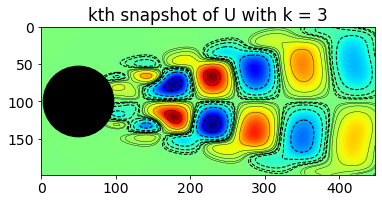

In [10]:
#c) Fix a value r=10 and compute the truncated SVD.
# Each column w_k of the matrix W=SigmatildeV* represents the mixture of 1 first 10 eigenflows in the kth column
# of X. Verify this by comparing the kth snapshot of X with Utilde_w_k

r_1 = 10
vortall_approx = U[:,:r_1] @ S[0:r_1,:r_1] @ VT[:r_1,:]


k = 3
plt.subplot(2,1,1)
plt.title('kth snapshot of X with k = ' + str(k))
EigenflowField(vortall[:,k])
plt.subplot(2,1,2)
plt.title('kth snapshot of U with k = '+ str(k))
EigenflowField(U[:,k])
plt.show()

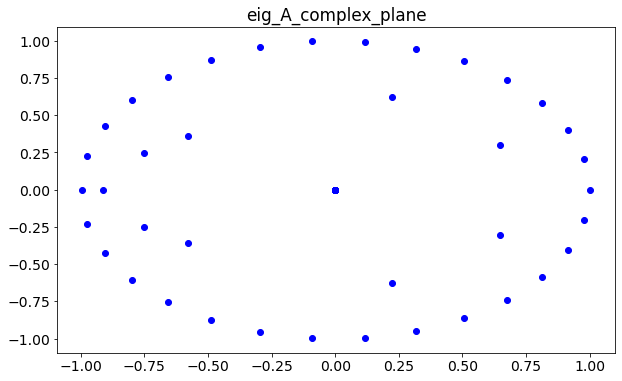

In [11]:
# d) Built a linear regression model fo r how the amplitude w_k evolve in time: this will be a dynamical system: w_k+1 = Aw_k 

# Create a matrix W with the first 1 throgh m-1 columns of SigmaV*. We will now try to solve for the best-fit A matrix so that
# W' = A*W. Compute the SVD of W and use this to compute the pseudo inverse of W to solve for A. 

SVT = S @ VT
m = 40
W = SVT[:,:m-1] # matrix W with the first 1 throgh m-1 columns of SigmaV*
W_prime = SVT[:,1:m] #(w_k+1)
W_U, W_S, W_VT = np.linalg.svd(W, full_matrices=False) 

W_S = np.diag(W_S)
W_pseudo_inv = W_VT.transpose() @ np.linalg.inv(W_S) @ W_U.transpose()

#Compute the eigenvalues of A 
# and plot the in the complex plane. 
A = W_prime @ W_pseudo_inv
eig_A = np.linalg.eig(A)


X = [x.real for x in eig_A[0]]
Y = [x.imag for x in eig_A[0]]
plt.scatter(X,Y, color='b')
plt.title('eig_A_complex_plane')
plt.show()

In [12]:
# e) Use this matrix A to advance the state w_k+1 = A^(k-1)w_1 starting from w_1. 
w_1 = SVT[:,:1]
SVT_1 = SVT[:,:1]

for i in range(1,n):
    w_new = A @ w_1
    SVT_1 = np.append(SVT_1, w_new, axis=1) #update SVT
    w_1 = w_new
    
vortall_new = U @ SVT_1

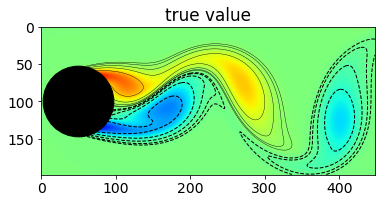

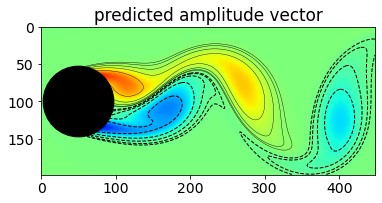

In [13]:
# Plot the reconstructed flow field using these predicted amplitude vectors and compare with the true values.

plt.subplot(2,1,1)
plt.title('true value')
EigenflowField(vortall[:,10])
plt.subplot(2,1,2)
plt.title('predicted amplitude vector')
EigenflowField(vortall_new[:,10])
plt.show()